In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")

In [2]:
import os
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from collections import defaultdict
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
from rule_utils import get_rule_img, get_obj_list, get_rule_list
from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract

In [4]:
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch

In [5]:
import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


### Load in model

In [6]:
DiT_configs = {
    # "DiT_XL_2": {"depth": 28, "hidden_size": 1152, "patch_size": 2, "num_heads": 16},
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    # "DiT_XL_4": {"depth": 28, "hidden_size": 1152, "patch_size": 4, "num_heads": 16},
    # "DiT_XL_8": {"depth": 28, "hidden_size": 1152, "patch_size": 8, "num_heads": 16},
    # "DiT_L_2": {"depth": 24, "hidden_size": 1024, "patch_size": 2, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    # "DiT_L_4": {"depth": 24, "hidden_size": 1024, "patch_size": 4, "num_heads": 16},
    # "DiT_L_8": {"depth": 24, "hidden_size": 1024, "patch_size": 8, "num_heads": 16},
    # "DiT_B_2": {"depth": 12, "hidden_size": 768, "patch_size": 2, "num_heads": 12},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    # "DiT_B_4": {"depth": 12, "hidden_size": 768, "patch_size": 4, "num_heads": 12},
    # "DiT_B_8": {"depth": 12, "hidden_size": 768, "patch_size": 8, "num_heads": 12},
    # "DiT_S_2": {"depth": 12, "hidden_size": 384, "patch_size": 2, "num_heads": 6},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
    # "DiT_S_4": {"depth": 12, "hidden_size": 384, "patch_size": 4, "num_heads": 6},
    # "DiT_S_8": {"depth": 12, "hidden_size": 384, "patch_size": 8, "num_heads": 6},
}

In [10]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


In [7]:
from diffusion import create_diffusion
from models import DiT

device = "cuda"
diffusion_eval = create_diffusion(timestep_respacing="ddim200")  # default: ddim100

In [8]:
class_dropout_prob = 1.0
num_classes = 0
model_cfg = DiT_configs["DiT_S_1"]
model = DiT(input_size=9,
            in_channels=3, **model_cfg,
            mlp_ratio=4.0,
            class_dropout_prob=class_dropout_prob,
            num_classes=num_classes,
            learn_sigma=True,)

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")

ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model.load_state_dict(state_dict["model"])
model.to("cuda").eval();

In [9]:
# from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

### Loading Training Attrs

In [17]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)

train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)

In [18]:
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

In [19]:
print(train_sample_img[0,0])

tensor([[[ 5,  5,  5,  5,  5, -1,  5, -1,  5],
         [ 5,  5,  5, -1, -1,  5,  5,  5,  5],
         [ 5,  5,  5,  5, -1, -1, -1,  5,  5],
         [-1,  6,  6,  6, -1, -1,  6,  6,  6],
         [-1, -1, -1, -1,  6,  6,  6,  6,  6],
         [-1,  6,  6,  6,  6, -1, -1,  6,  6],
         [ 2, -1,  2,  2,  2,  2, -1, -1,  2],
         [ 2,  2, -1,  2, -1, -1, -1, -1, -1],
         [ 2,  2,  2, -1,  2,  2,  2,  2, -1]],

        [[ 4,  4,  4,  2,  2, -1,  9, -1,  9],
         [ 4,  4,  4, -1, -1,  2,  9,  9,  9],
         [ 4,  4,  4,  2, -1, -1, -1,  9,  9],
         [-1,  5,  1,  5, -1, -1,  7,  1,  5],
         [-1, -1, -1, -1,  0,  1,  7,  4,  0],
         [-1,  3,  1,  8,  2, -1, -1,  7,  6],
         [ 5, -1,  5,  3,  3,  3, -1, -1,  6],
         [ 5,  5, -1,  3, -1, -1, -1, -1, -1],
         [ 5,  5,  5, -1,  3,  3,  6,  6, -1]],

        [[ 4,  8,  4,  5,  0, -1,  6, -1,  4],
         [ 0,  5,  4, -1, -1,  1,  2,  5,  8],
         [ 7,  3,  1,  2, -1, -1, -1,  8,  2],
         

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


In [21]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")

### Test run and rule inference

In [10]:
y = th.zeros(1024, dtype=torch.int, device="cuda")
model_kwargs = dict(y=y)
with th.no_grad():
    samples = diffusion_eval.ddim_sample_loop(model, shape=(1024, 3, 9, 9), clip_denoised=False, device="cuda", model_kwargs=model_kwargs, progress=True)
samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()

  0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)

In [14]:
sum([len(r3_rule) > 0 for r3_rule in r3_list]) / len(r3_list), \
sum([len(r2_rule) > 0 for r2_rule in r2_list]) / len(r2_list)

(0.603515625, 0.15625)

### Prepare feautres fetching machinery

In [11]:
get_module_name_shapes(model,inputs_list=[torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), ], 
                       model_kwargs={"y":torch.zeros(2, dtype=torch.int, device="cuda")});

------------------------------------------------------------------------------------------------------------------------------------------------------
      Layer Id                                           inshape                    outshape                            Type   Module Path                      
        0                                             (2, 3, 9, 9)                (2, 3, 9, 9)                         [Input]   Image                            
        1                                           [(2, 3, 9, 9)]              (2, 384, 9, 9)                        [Conv2d]   .x_embedder.proj                 
        2                                           [(2, 81, 384)]                (2, 81, 384)                      [Identity]   .x_embedder.norm                 
        3                                           [(2, 3, 9, 9)]                (2, 81, 384)                    [PatchEmbed]   .x_embedder                      
        4                           

In [19]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in range(12):
    fetcher.record_module(model.blocks[i], target_name=f"blocks.{i}")

In [ ]:

# layerkey = "blocks.11"
fetcher = featureFetcher_module()
for i in [0,2,5,8,11]: #range(12):
    fetcher.record_module(model.blocks[i], target_name=f"blocks.{i}")
    
train_loader = DataLoader(train_dataset, batch_size=1524, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1524, shuffle=False)
t_scalar = 0.1
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.67it/s]


blocks.0 torch.Size([120000, 81, 384])
blocks.2 torch.Size([120000, 81, 384])
blocks.5 torch.Size([120000, 81, 384])
blocks.8 torch.Size([120000, 81, 384])
blocks.11 torch.Size([120000, 81, 384])


In [18]:
feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.71it/s]


blocks.0 torch.Size([40000, 81, 384])
blocks.2 torch.Size([40000, 81, 384])
blocks.5 torch.Size([40000, 81, 384])
blocks.8 torch.Size([40000, 81, 384])
blocks.11 torch.Size([40000, 81, 384])


### Train classifier

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


# Define the training loop
def train_model(model, train_loader, num_epochs, learning_rate, print_every=50,
                eval_every=500, eval_func=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_record = []
    test_record = []
    for epoch in range(num_epochs):
        acc_total = 0
        cnt_total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc_cnt = (outputs.argmax(dim=1) == labels).sum().item()
            acc_total += acc_cnt
            cnt_total += len(labels)
        accuracy = acc_total / cnt_total
        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
        train_record.append((epoch, loss.item(), accuracy))
        if ((epoch + 1) % eval_every == 0 or epoch == num_epochs - 1) and eval_func is not None:
            test_acc, _ = eval_func(model)
            test_record.append((epoch, test_acc))
    train_record = pd.DataFrame(train_record, columns=["epoch", "loss", "accuracy"])
    test_record = pd.DataFrame(test_record, columns=["epoch", "accuracy"])
    return train_record, test_record


def test_model(model, test_loader):
    acc_total = 0
    cnt_total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        with th.no_grad():
            outputs = model(inputs)
        pred_cls = outputs.argmax(dim=1)
        acc_cnt = (pred_cls == labels).sum().item()
        acc_total += acc_cnt
        cnt_total += len(labels)
    accuracy = acc_total / cnt_total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, pred_cls


def fit_SGD_linear_classifier(train_X, train_y, test_X=None, test_y=None, 
                              num_classes=40, 
                              batch_size=1024, num_epochs=100, 
                              learning_rate = 0.001, print_every=100, eval_every=500,):
    # Define the linear classifier model
    input_size = train_X.shape[1]
    model = LinearClassifier(input_size, num_classes).to("cuda")
    if batch_size is None:
        feat_loader = [(train_X.to("cuda"), train_y.to("cuda"))]
    else:
        feat_dataset = TensorDataset(train_X.to("cuda"), train_y.to("cuda")) # .to("cuda")
        feat_loader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True,
                             drop_last=True) # pin_memory=True, num_workers=
    
    if test_X is not None and test_y is not None:
        if batch_size is None:
            test_feat_loader = [(test_X.to("cuda"), test_y.to("cuda"))]
        else:
            test_dataset = TensorDataset(test_X.to("cuda"), test_y.to("cuda")) # .to("cuda")
            test_feat_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Define the training loop
    train_record, test_record = train_model(model, feat_loader, num_epochs, learning_rate, print_every=print_every, eval_every=eval_every,
                eval_func=lambda model: test_model(model, test_feat_loader) if test_feat_loader is not None else None)
    # Define the testing loop
    test_acc, pred_cls = test_model(model, test_feat_loader)
    results = edict()
    results.train_record = train_record
    results.test_record = test_record
    results.test_acc = test_acc
    results.pred_cls = pred_cls
    return model, results


### Full space classification

In [34]:
feature_col["blocks.11"].shape

torch.Size([105000, 81, 384])

In [37]:
# feature_col["blocks.11"].view(len(train_dataset),-1)
model = fit_SGD_linear_classifier(feature_col["blocks.11"].view(len(train_dataset),-1), y_train,
                                  feature_col_test["blocks.11"].view(len(test_dataset),-1), y_test,
                                  num_classes=35, batch_size=1024, num_epochs=100, 
                                  learning_rate = 0.0001)

Epoch [1/100], Loss: 1.9308435916900635, Accuracy: 0.26777142857142855
Epoch [2/100], Loss: 1.5436296463012695, Accuracy: 0.5019333333333333
Epoch [3/100], Loss: 1.374857783317566, Accuracy: 0.565952380952381
Epoch [4/100], Loss: 1.3158166408538818, Accuracy: 0.6008285714285714
Epoch [5/100], Loss: 1.3251842260360718, Accuracy: 0.6225142857142857
Epoch [6/100], Loss: 1.1655837297439575, Accuracy: 0.6448761904761905
Epoch [7/100], Loss: 1.2005559206008911, Accuracy: 0.6575619047619048
Epoch [8/100], Loss: 1.0987610816955566, Accuracy: 0.6686952380952381
Epoch [9/100], Loss: 1.0566843748092651, Accuracy: 0.6790380952380952
Epoch [10/100], Loss: 0.9980524182319641, Accuracy: 0.6883523809523809
Epoch [11/100], Loss: 0.9466462135314941, Accuracy: 0.6993238095238096
Epoch [12/100], Loss: 0.9482499361038208, Accuracy: 0.7020380952380952
Epoch [13/100], Loss: 0.9276266694068909, Accuracy: 0.7105142857142858
Epoch [14/100], Loss: 0.93211430311203, Accuracy: 0.716047619047619
Epoch [15/100], Los

KeyboardInterrupt: 

In [38]:
model_col = {}
for layerkey in ["blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    model = fit_SGD_linear_classifier(feature_col[layerkey].view(len(train_dataset),-1), y_train,
                                    feature_col_test[layerkey].view(len(test_dataset),-1), y_test,
                                    num_classes=35, batch_size=2048, num_epochs=100, 
                                    learning_rate = 0.0001)
    model_col[layerkey] = model

Epoch [1/100], Loss: 2.2973532676696777, Accuracy: 0.21150476190476192
Epoch [2/100], Loss: 2.0716938972473145, Accuracy: 0.3788285714285714
Epoch [3/100], Loss: 1.8989094495773315, Accuracy: 0.420352380952381
Epoch [4/100], Loss: 1.8414195775985718, Accuracy: 0.44416190476190476
Epoch [5/100], Loss: 1.7178688049316406, Accuracy: 0.46336190476190475
Epoch [6/100], Loss: 1.7495827674865723, Accuracy: 0.4742857142857143
Epoch [7/100], Loss: 1.6716333627700806, Accuracy: 0.4844380952380952
Epoch [8/100], Loss: 1.6283797025680542, Accuracy: 0.48984761904761903
Epoch [9/100], Loss: 1.686915397644043, Accuracy: 0.4932190476190476
Epoch [10/100], Loss: 1.633623480796814, Accuracy: 0.49583809523809524
Epoch [11/100], Loss: 1.6043235063552856, Accuracy: 0.5024761904761905
Epoch [12/100], Loss: 1.5791165828704834, Accuracy: 0.5078190476190476
Epoch [13/100], Loss: 1.5566612482070923, Accuracy: 0.5087238095238096
Epoch [14/100], Loss: 1.576779842376709, Accuracy: 0.510552380952381
Epoch [15/100],

### PC dim reduction

In [20]:
layerkey = "blocks.11"
feature_col[layerkey].view(len(train_dataset),-1).shape

torch.Size([120000, 31104])

In [35]:
th.cuda.empty_cache()

In [39]:
import time
layerkey = "blocks.11"
PC_dim = 1000
t0 = time.time()
featmat = feature_col[layerkey].view(len(train_dataset),-1)
featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
featmean = featmat.mean(dim=0)
U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
print(U.shape, S.shape, V.shape)
del U, S
torch.cuda.empty_cache()
t1 = time.time()
feat_PCA = (featmat - featmean[None,]).cuda() @ V
feat_PCA_std = feat_PCA.std(dim=0)
feat_PCA = feat_PCA / feat_PCA_std
feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
feat_PCA_test = feat_PCA_test / feat_PCA_std
torch.cuda.empty_cache()
t2 = time.time()
print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}")

torch.Size([120000, 1000]) torch.Size([1000]) torch.Size([31104, 1000])
Layer blocks.11 PCA time: 11.12, PCA transform time: 7.31


In [96]:
PC_dim = 512

model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
    print(U.shape, S.shape, V.shape)
    del U, S
    torch.cuda.empty_cache()
    t1 = time.time()
    feat_PCA = (featmat - featmean[None,]).cuda() @ V
    feat_PCA_std = feat_PCA.std(dim=0)
    feat_PCA = feat_PCA / feat_PCA_std
    feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
    feat_PCA_test = feat_PCA_test / feat_PCA_std
    torch.cuda.empty_cache()
    V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict

repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
pkl.dump(results_col, open(join(repr_expdir,f"results_col_PC{PC_dim}.pkl"), "wb"))
pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_PC{PC_dim}.pkl"), "wb"))
pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_PC{PC_dim}.pkl"), "wb"))

torch.Size([120000, 512]) torch.Size([512]) torch.Size([31104, 512])
Epoch [1/5000], Loss: 3.8653, Accuracy: 0.0232
Epoch [250/5000], Loss: 2.1192, Accuracy: 0.3962
Epoch [500/5000], Loss: 1.9625, Accuracy: 0.4251
Epoch [750/5000], Loss: 1.9054, Accuracy: 0.4363
Epoch [1000/5000], Loss: 1.8773, Accuracy: 0.4429
Test Accuracy: 0.3917
Epoch [1250/5000], Loss: 1.8613, Accuracy: 0.4464
Epoch [1500/5000], Loss: 1.8513, Accuracy: 0.4488
Epoch [1750/5000], Loss: 1.8444, Accuracy: 0.4503
Epoch [2000/5000], Loss: 1.8395, Accuracy: 0.4512
Test Accuracy: 0.4012
Epoch [2250/5000], Loss: 1.8357, Accuracy: 0.4523
Epoch [2500/5000], Loss: 1.8328, Accuracy: 0.4530
Epoch [2750/5000], Loss: 1.8304, Accuracy: 0.4534
Epoch [3000/5000], Loss: 1.8284, Accuracy: 0.4537
Test Accuracy: 0.4039
Epoch [3250/5000], Loss: 1.8268, Accuracy: 0.4544
Epoch [3500/5000], Loss: 1.8254, Accuracy: 0.4548
Epoch [3750/5000], Loss: 1.8242, Accuracy: 0.4549
Epoch [4000/5000], Loss: 1.8231, Accuracy: 0.4551
Test Accuracy: 0.4055

<Axes: >

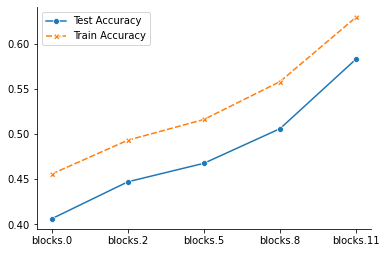

In [97]:
test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
syn_df.columns = ["Test Accuracy", "Train Accuracy"]
sns.lineplot(data=syn_df, markers=True)

In [98]:
syn_df

,Test Accuracy,Train Accuracy
blocks.0,0.406325,0.455917
blocks.2,0.447250,0.493308
blocks.5,0.467750,0.516300
blocks.8,0.506125,0.558242
blocks.11,0.583300,0.629658


In [75]:
PC_dim = 1024

model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
    print(U.shape, S.shape, V.shape)
    del U, S
    torch.cuda.empty_cache()
    t1 = time.time()
    feat_PCA = (featmat - featmean[None,]).cuda() @ V
    feat_PCA_std = feat_PCA.std(dim=0)
    feat_PCA = feat_PCA / feat_PCA_std
    feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
    feat_PCA_test = feat_PCA_test / feat_PCA_std
    torch.cuda.empty_cache()
    V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict

repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
pkl.dump(results_col, open(join(repr_expdir,f"results_col_PC{PC_dim}.pkl"), "wb"))
pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_PC{PC_dim}.pkl"), "wb"))
pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_PC{PC_dim}.pkl"), "wb"))

torch.Size([120000, 1024]) torch.Size([1024]) torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8545, Accuracy: 0.0238
Epoch [250/5000], Loss: 1.8201, Accuracy: 0.4684
Epoch [500/5000], Loss: 1.6468, Accuracy: 0.5026
Epoch [750/5000], Loss: 1.5772, Accuracy: 0.5164
Epoch [1000/5000], Loss: 1.5403, Accuracy: 0.5240
Test Accuracy: 0.4244
Epoch [1250/5000], Loss: 1.5178, Accuracy: 0.5290
Epoch [1500/5000], Loss: 1.5030, Accuracy: 0.5324
Epoch [1750/5000], Loss: 1.4924, Accuracy: 0.5347
Epoch [2000/5000], Loss: 1.4846, Accuracy: 0.5365
Test Accuracy: 0.4375
Epoch [2250/5000], Loss: 1.4786, Accuracy: 0.5379
Epoch [2500/5000], Loss: 1.4738, Accuracy: 0.5393
Epoch [2750/5000], Loss: 1.4698, Accuracy: 0.5408
Epoch [3000/5000], Loss: 1.4666, Accuracy: 0.5418
Test Accuracy: 0.4417
Epoch [3250/5000], Loss: 1.4638, Accuracy: 0.5426
Epoch [3500/5000], Loss: 1.4615, Accuracy: 0.5432
Epoch [3750/5000], Loss: 1.4595, Accuracy: 0.5437
Epoch [4000/5000], Loss: 1.4578, Accuracy: 0.5442
Test Accuracy: 0.4

<Axes: >

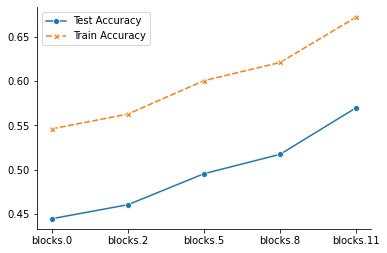

In [ ]:
test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
syn_df.columns = ["Test Accuracy", "Train Accuracy"]
sns.lineplot(data=syn_df, markers=True)

In [ ]:
syn_df

,Test Accuracy,Train Accuracy
blocks.0,0.444900,0.546150
blocks.2,0.460675,0.562892
blocks.5,0.495650,0.600558
blocks.8,0.517500,0.621025
blocks.11,0.570025,0.672175


In [90]:
PC_dim = 2048

model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
    print(U.shape, S.shape, V.shape)
    del U, S
    torch.cuda.empty_cache()
    t1 = time.time()
    feat_PCA = (featmat - featmean[None,]).cuda() @ V
    feat_PCA_std = feat_PCA.std(dim=0)
    feat_PCA = feat_PCA / feat_PCA_std
    feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
    feat_PCA_test = feat_PCA_test / feat_PCA_std
    torch.cuda.empty_cache()
    V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict

repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
pkl.dump(results_col, open(join(repr_expdir,f"results_col_PC{PC_dim}.pkl"), "wb"))
pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_PC{PC_dim}.pkl"), "wb"))
pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_PC{PC_dim}.pkl"), "wb"))

torch.Size([120000, 2048]) torch.Size([2048]) torch.Size([31104, 2048])
Epoch [1/5000], Loss: 3.8498, Accuracy: 0.0248
Epoch [250/5000], Loss: 1.5140, Accuracy: 0.5567
Epoch [500/5000], Loss: 1.3492, Accuracy: 0.5908
Epoch [750/5000], Loss: 1.2766, Accuracy: 0.6078
Epoch [1000/5000], Loss: 1.2342, Accuracy: 0.6176
Test Accuracy: 0.4076
Epoch [1250/5000], Loss: 1.2061, Accuracy: 0.6255
Epoch [1500/5000], Loss: 1.1862, Accuracy: 0.6306
Epoch [1750/5000], Loss: 1.1714, Accuracy: 0.6344
Epoch [2000/5000], Loss: 1.1600, Accuracy: 0.6377
Test Accuracy: 0.4206
Epoch [2250/5000], Loss: 1.1511, Accuracy: 0.6401
Epoch [2500/5000], Loss: 1.1439, Accuracy: 0.6417
Epoch [2750/5000], Loss: 1.1380, Accuracy: 0.6433
Epoch [3000/5000], Loss: 1.1331, Accuracy: 0.6448
Test Accuracy: 0.4250
Epoch [3250/5000], Loss: 1.1289, Accuracy: 0.6458
Epoch [3500/5000], Loss: 1.1254, Accuracy: 0.6467
Epoch [3750/5000], Loss: 1.1223, Accuracy: 0.6476
Epoch [4000/5000], Loss: 1.1196, Accuracy: 0.6482
Test Accuracy: 0.4

<Axes: >

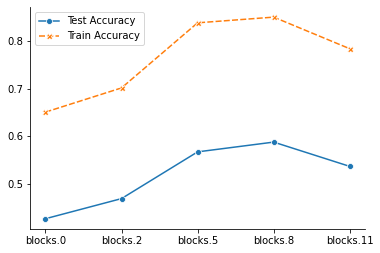

In [94]:
test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
syn_df.columns = ["Test Accuracy", "Train Accuracy"]
sns.lineplot(data=syn_df, markers=True)

In [95]:
syn_df

,Test Accuracy,Train Accuracy
blocks.0,0.426700,0.650608
blocks.2,0.468950,0.701383
blocks.5,0.567100,0.838125
blocks.8,0.587625,0.850100
blocks.11,0.536600,0.783700


In [93]:
!du -sh {expdir}/repr_classifier/*

808K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/repr_classifier/model_PCA_col_PC1024.pkl
1.6M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/repr_classifier/model_PCA_col_PC2048.pkl
609M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/repr_classifier/PC_proj_col_PC1024.pkl
1.2G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/repr_classifier/PC_proj_col_PC2048.pkl
2.2M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/repr_classifier/results_col_PC1024.pkl
2.2M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-un

### Different time 

In [23]:
import time

In [24]:
# model_DiT
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")

class_dropout_prob = 1.0
num_classes = 0
model_cfg = DiT_configs["DiT_S_1"]
model_DiT = DiT(input_size=9,
            in_channels=3, **model_cfg,
            mlp_ratio=4.0,
            class_dropout_prob=class_dropout_prob,
            num_classes=num_classes,
            learn_sigma=True,)

ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_DiT.load_state_dict(state_dict["model"])
model_DiT.to("cuda").eval();

  0%|                                                                                                          | 0/79 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:05<00:00,  1.21it/s]


blocks.0 torch.Size([120000, 81, 384])
blocks.2 torch.Size([120000, 81, 384])
blocks.5 torch.Size([120000, 81, 384])
blocks.8 torch.Size([120000, 81, 384])
blocks.11 torch.Size([120000, 81, 384])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:21<00:00,  1.24it/s]


blocks.0 torch.Size([40000, 81, 384])
blocks.2 torch.Size([40000, 81, 384])
blocks.5 torch.Size([40000, 81, 384])
blocks.8 torch.Size([40000, 81, 384])
blocks.11 torch.Size([40000, 81, 384])
Feature extraction time: 130.60
torch.Size([120000, 1024]) torch.Size([1024]) torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8530, Accuracy: 0.0251
Epoch [250/5000], Loss: 1.8198, Accuracy: 0.4685
Epoch [500/5000], Loss: 1.6463, Accuracy: 0.5028
Epoch [750/5000], Loss: 1.5765, Accuracy: 0.5167
Epoch [1000/5000], Loss: 1.5395, Accuracy: 0.5249
Test Accuracy: 0.4247
Epoch [1250/5000], Loss: 1.5169, Accuracy: 0.5302
Epoch [1500/5000], Loss: 1.5020, Accuracy: 0.5336
Epoch [1750/5000], Loss: 1.4915, Accuracy: 0.5363
Epoch [2000/5000], Loss: 1.4837, Accuracy: 0.5380
Test Accuracy: 0.4386
Epoch [2250/5000], Loss: 1.4776, Accuracy: 0.5396
Epoch [2500/5000], Loss: 1.4728, Accuracy: 0.5411
Epoch [2750/5000], Loss: 1.4688, Accuracy: 0.5424
Epoch [3000/5000], Loss: 1.4656, Accuracy: 0.5433
Test Accuracy: 0.

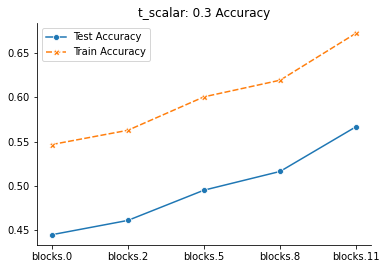

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:04<00:00,  1.22it/s]


: 

: 

: 

In [26]:
import time
from tqdm import tqdm
from collections import defaultdict
fetcher = featureFetcher_module()
for i in [0, 2, 5, 8, 11]: 
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks.{i}")

t_scalar = 0.1
for t_scalar in [0.5, 0.7, 0.9, 1.0, 0.05, 0.02, 0.1]: # 0.3, 
    t_beg = time.time()
    train_loader = DataLoader(train_dataset, batch_size=1524, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=1524, shuffle=False)
    feature_col = defaultdict(list)
    for X_batch, y_batch in tqdm(train_loader):
        model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_DiT.forward(X_batch_norm, t_vec, **model_kwargs)
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations)
    for key in feature_col.keys():
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(key, feature_col[key].shape)

    feature_col_test = defaultdict(list)
    for X_batch, y_batch in tqdm(test_loader):
        model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_DiT.forward(X_batch_norm, t_vec, **model_kwargs)
        for key, activations in fetcher.activations.items():
            feature_col_test[key].append(activations)
            
    for key in feature_col_test.keys():
        feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
        print(key, feature_col_test[key].shape)
    th.cuda.empty_cache() 
    t_feat = time.time()
    print(f"Feature extraction time: {t_feat - t_beg:.2f}")
    
    PC_dim = 1024
    model_PCA_col = {}
    PC_proj_col = {}
    results_col = {}
    for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
        t0 = time.time()
        featmat = feature_col[layerkey].view(len(train_dataset),-1)
        featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
        featmean = featmat.mean(dim=0)
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        t1 = time.time()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std
        torch.cuda.empty_cache()
        V = V.cpu()
        t2 = time.time()
        model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                        num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                        eval_every=1000, learning_rate=0.005)
        t3 = time.time()
        print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
        model_PCA_col[layerkey] = model
        PC_proj_col[layerkey] = (V.cpu(), featmean.cpu(), feat_PCA_std.cpu())
        results_col[layerkey] = results_dict

    repr_expdir = join(expdir, "repr_classifier")
    os.makedirs(repr_expdir, exist_ok=True)
    t_str = str(t_scalar).replace('.', '_')
    
    pkl.dump(results_col, open(join(repr_expdir,f"results_col_t{t_str}_PC{PC_dim}.pkl"), "wb"))
    pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_t{t_str}_PC{PC_dim}.pkl"), "wb"))
    pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_t{t_str}_PC{PC_dim}.pkl"), "wb"))
    
    test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
    train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
    syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
    syn_df.columns = ["Test Accuracy", "Train Accuracy"]
    
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=syn_df, markers=True)
    plt.title(f"t_scalar: {t_scalar} Accuracy")
    plt.savefig(join(repr_expdir,f"t{t_str}_PC{PC_dim}_accuracy.png"))
    plt.savefig(join(repr_expdir,f"t{t_str}_PC{PC_dim}_accuracy.pdf"))
    plt.show()

In [107]:
t_str = str(t_scalar).replace('.', '_')

In [108]:
f"results_col_t{t_str}_PC{PC_dim}.pkl"

'results_col_t0_1_PC512.pkl'

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [64]:
inset_rules = [i for i in range(40) if i not in heldout_rules]
indist_acc = np.diag(cm)[inset_rules].mean() / 1000
heldout_acc = np.diag(cm)[heldout_rules].mean() / 1000
print(f"Indistinct accuracy: {indist_acc:.4f}, Heldout accuracy: {heldout_acc:.4f}")

Indistinct accuracy: 0.5593, Heldout accuracy: 0.6332


In [68]:
heldout_rules

[1, 16, 20, 34, 37]

Layer blocks.0 PCA transform time: 1.98, testing time: 0.00


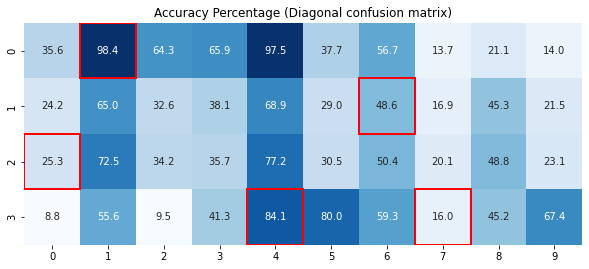

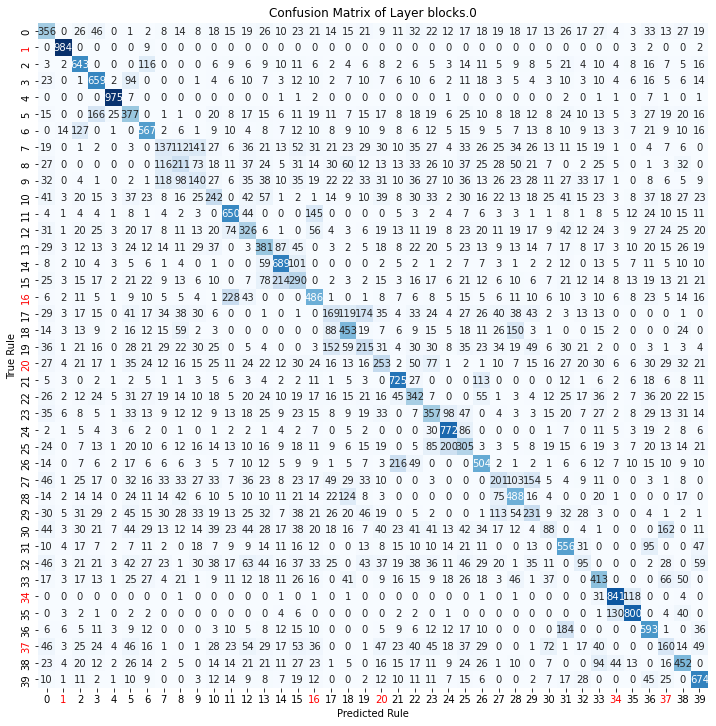

Layer blocks.2 PCA transform time: 1.99, testing time: 0.00


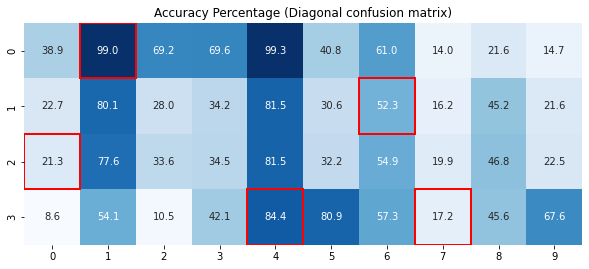

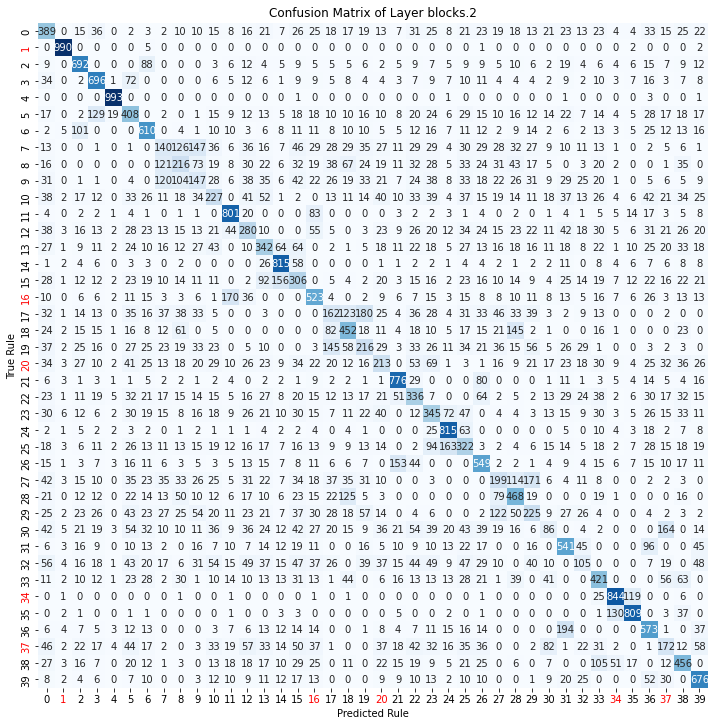

Layer blocks.5 PCA transform time: 2.01, testing time: 0.00


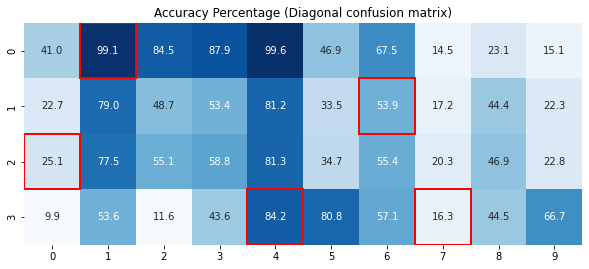

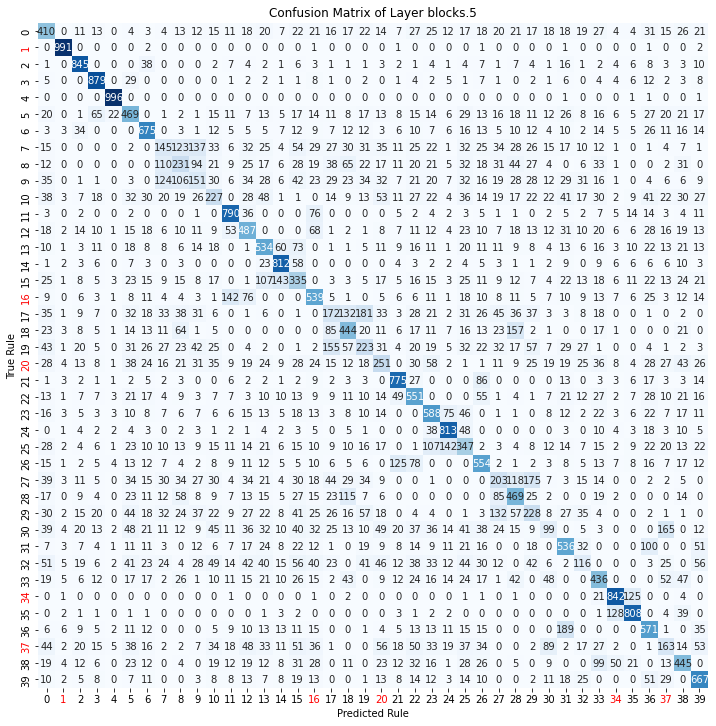

Layer blocks.8 PCA transform time: 2.01, testing time: 0.00


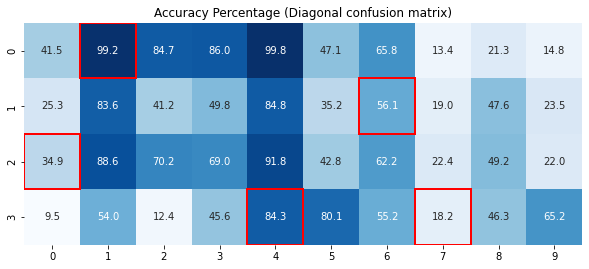

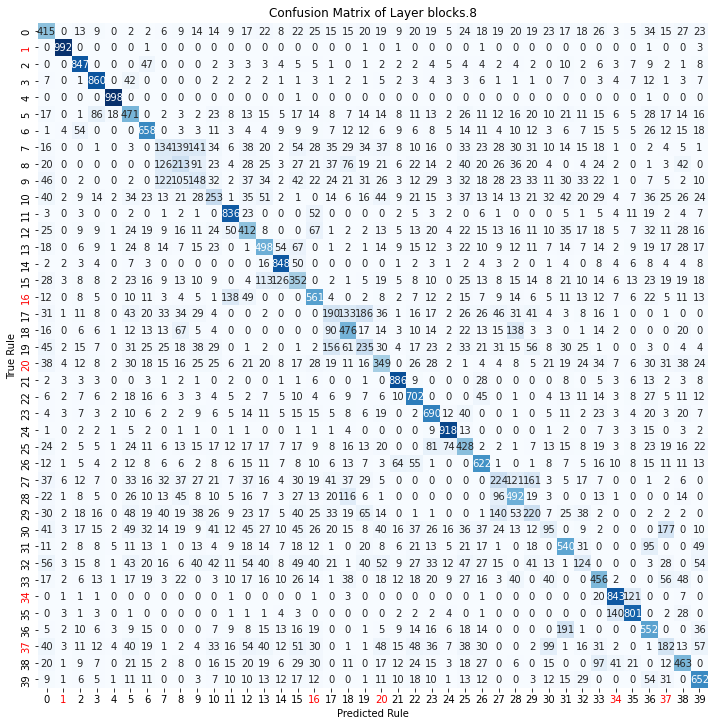

Layer blocks.11 PCA transform time: 1.99, testing time: 0.00


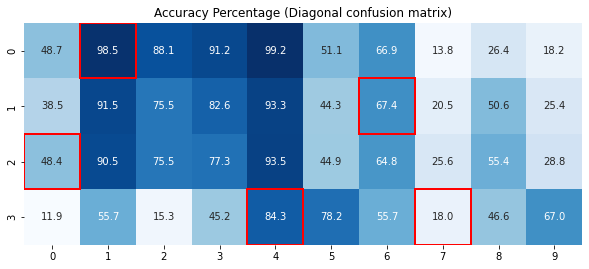

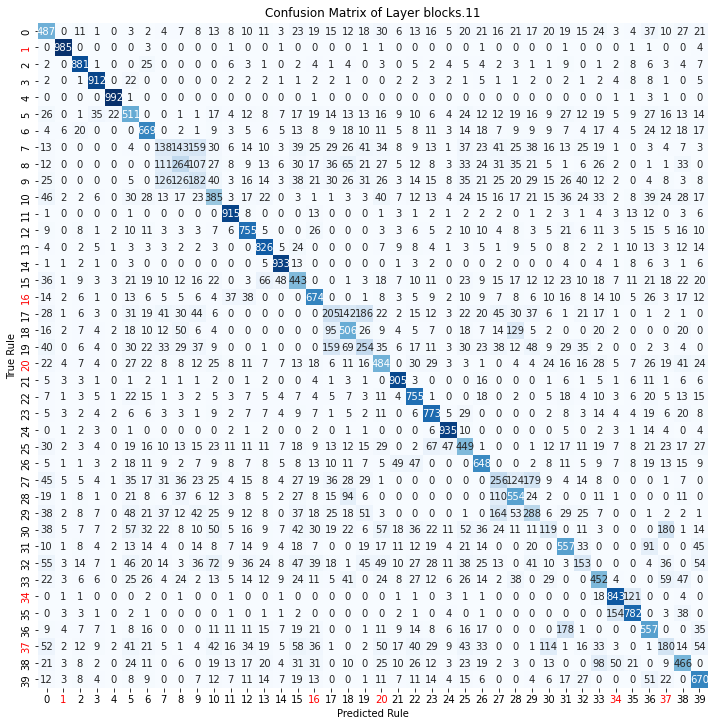

In [72]:
# dissect the error, by plotting the confusion matrix
for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    V, feat_PCA_mean, feat_PCA_std = PC_proj_col[layerkey]
    # feat_PCA = ((featmat - feat_PCA_mean) @ V ) / feat_PCA_std
    feat_PCA_test = ((featmat_test - feat_PCA_mean).cuda() @ V.cuda() ) / feat_PCA_std.cuda()
    torch.cuda.empty_cache()
    t2 = time.time()
    model = model_PCA_col[layerkey]
    model.eval()
    with torch.no_grad():
        outputs = model(feat_PCA_test)
        pred = outputs.argmax(dim=1).cpu().numpy()
        y_test_np = y_test.cpu().numpy()
    t3 = time.time()
    print(f"Layer {layerkey} PCA transform time: {t2-t0:.2f}, testing time: {t3-t2:.2f}")
    cm = confusion_matrix(y_test_np, pred)
    
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    for rule_id in heldout_rules:
        row = rule_id // 10
        col = rule_id % 10
        plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title("Accuracy Percentage (Diagonal confusion matrix)")
    plt.show()
    
    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix of Layer {layerkey}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()

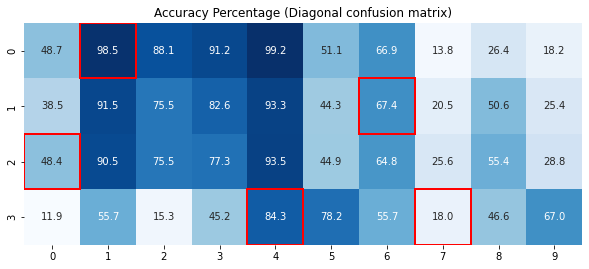

In [70]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(10, 4))
sns.heatmap(np.diag(cm).reshape(4,10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
for rule_id in heldout_rules:
    row = rule_id // 10
    col = rule_id % 10
    plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
plt.title("Accuracy Percentage (Diagonal confusion matrix)")
plt.show()

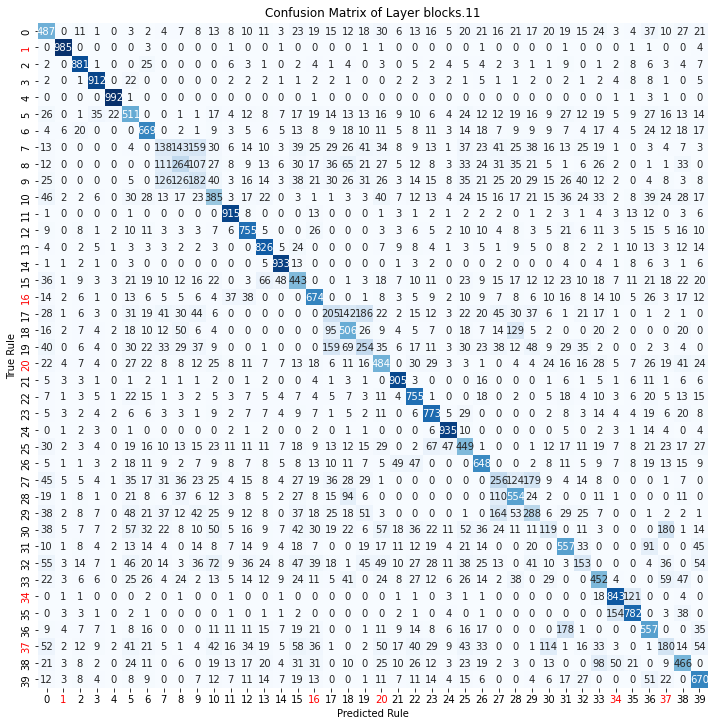

In [ ]:
figh = plt.figure(figsize=(12, 12))
ax = figh.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix of Layer {layerkey}")
plt.ylabel('True Rule')
plt.xlabel('Predicted Rule')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    if int(label.get_text()) in heldout_rules:
        label.set_color('red')
# heldout_rules
plt.show()

In [69]:
PC_dim
model_PCA_col = {}
for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    U, S, V = torch.pca_lowrank(featmat.cuda(), q=1000, center=True, niter=5)
    print(U.shape, S.shape, V.shape)
    torch.cuda.empty_cache()
    feat_PCA = featmat.cuda() @ V
    feat_PCA_mean, feat_PCA_std = feat_PCA.mean(dim=0), feat_PCA.std(dim=0)
    feat_PCA_norm = (feat_PCA - feat_PCA_mean) / feat_PCA_std
    feat_PCA_test = featmat_test.cuda() @ V
    feat_PCA_test_norm = (feat_PCA_test - feat_PCA_mean) / feat_PCA_std
    torch.cuda.empty_cache()
    model = fit_SGD_linear_classifier(feat_PCA_norm, y_train, feat_PCA_test_norm, y_test,
                                    num_classes=40, batch_size=8192, num_epochs=100, 
                                    learning_rate = 0.01)
    model_PCA_col[layerkey] = model

torch.Size([105000, 1000]) torch.Size([1000]) torch.Size([31104, 1000])
Epoch [1/100], Loss: 3.0417237281799316,
Epoch [2/100], Loss: 2.620983123779297,
Epoch [3/100], Loss: 2.374258518218994,
Epoch [4/100], Loss: 2.257586717605591,
Epoch [5/100], Loss: 2.1485774517059326,
Epoch [6/100], Loss: 2.067380905151367,
Epoch [7/100], Loss: 2.02142333984375,
Epoch [8/100], Loss: 1.9973657131195068,
Epoch [9/100], Loss: 1.959771752357483,
Epoch [10/100], Loss: 1.9263705015182495,
Epoch [11/100], Loss: 1.8806904554367065,
Epoch [12/100], Loss: 1.8760768175125122,
Epoch [13/100], Loss: 1.8468736410140991,
Epoch [14/100], Loss: 1.8375608921051025,
Epoch [15/100], Loss: 1.8073488473892212,
Epoch [16/100], Loss: 1.833194375038147,
Epoch [17/100], Loss: 1.7736588716506958,
Epoch [18/100], Loss: 1.7907594442367554,
Epoch [19/100], Loss: 1.7624098062515259,
Epoch [20/100], Loss: 1.7611767053604126,
Epoch [21/100], Loss: 1.7579679489135742,
Epoch [22/100], Loss: 1.7487592697143555,
Epoch [23/100], Loss:

In [90]:
del model
torch.cuda.empty_cache()


torch.Size([105000, 1000]) torch.Size([1000]) torch.Size([31104, 1000])
Layer blocks.2 PCA time: 7.54, PCA transform time: 2.26, testing time: 0.12


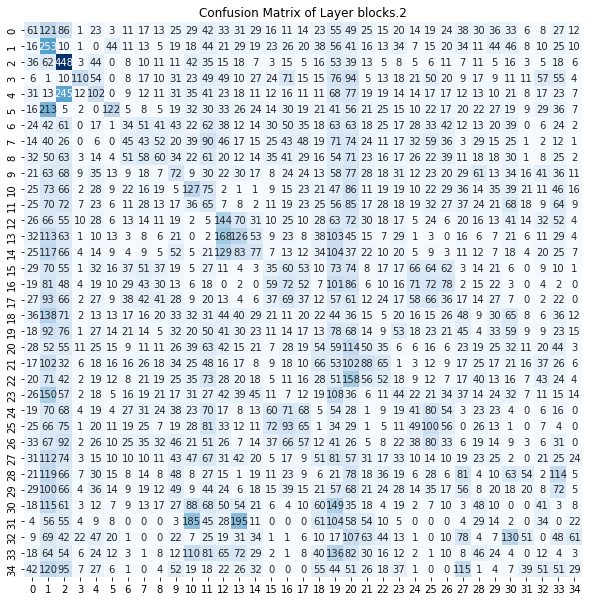

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.17 GiB (GPU 0; 39.39 GiB total capacity; 24.64 GiB already allocated; 1.28 GiB free; 37.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [83]:
# dissect the error, by plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for layerkey in ["blocks.0", "blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    U, S, V = torch.pca_lowrank(featmat.cuda(), q=PC_dim, center=True, niter=5)
    print(U.shape, S.shape, V.shape)
    torch.cuda.empty_cache()
    t1 = time.time()
    feat_PCA = featmat.cuda() @ V
    feat_PCA_mean, feat_PCA_std = feat_PCA.mean(dim=0), feat_PCA.std(dim=0)
    feat_PCA_norm = (feat_PCA - feat_PCA_mean) / feat_PCA_std
    feat_PCA_test = featmat_test.cuda() @ V
    feat_PCA_test_norm = (feat_PCA_test - feat_PCA_mean) / feat_PCA_std
    torch.cuda.empty_cache()
    t2 = time.time()
    model = model_col[layerkey]
    model.eval()
    with torch.no_grad():
        outputs = model(feat_PCA_test_norm)
        pred = outputs.argmax(dim=1).cpu().numpy()
        y_test_np = y_test.cpu().numpy()
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, testing time: {t3-t2:.2f}")
    cm = confusion_matrix(y_test_np, pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix of Layer {layerkey}")
    plt.show()

In [85]:
(y_test_np ==pred).mean()

0.07531428571428571

In [77]:
import time
model_PCA_col = {}
for layerkey in ["blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    U, S, V = torch.pca_lowrank(featmat.cuda(), q=2000, center=True, niter=5)
    print(U.shape, S.shape, V.shape)
    torch.cuda.empty_cache()
    t1 = time.time()
    feat_PCA = featmat.cuda() @ V
    feat_PCA_mean, feat_PCA_std = feat_PCA.mean(dim=0), feat_PCA.std(dim=0)
    feat_PCA_norm = (feat_PCA - feat_PCA_mean) / feat_PCA_std
    feat_PCA_test = featmat_test.cuda() @ V
    feat_PCA_test_norm = (feat_PCA_test - feat_PCA_mean) / feat_PCA_std
    torch.cuda.empty_cache()
    t2 = time.time()
    model = fit_SGD_linear_classifier(feat_PCA_norm, y_train, feat_PCA_test_norm, y_test,
                                    num_classes=35, batch_size=None, num_epochs=5000, print_every=100, eval_every=500,
                                    learning_rate=0.01)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_col[layerkey] = model

torch.Size([105000, 2000]) torch.Size([2000]) torch.Size([31104, 2000])
Epoch [1/5000], Loss: 3.7088, Accuracy: 0.0296
Epoch [100/5000], Loss: 1.3752, Accuracy: 0.5944
Epoch [200/5000], Loss: 1.2091, Accuracy: 0.6319
Epoch [300/5000], Loss: 1.1325, Accuracy: 0.6497
Epoch [400/5000], Loss: 1.0861, Accuracy: 0.6618
Epoch [500/5000], Loss: 1.0543, Accuracy: 0.6693
Epoch [600/5000], Loss: 1.0308, Accuracy: 0.6754
Epoch [700/5000], Loss: 1.0127, Accuracy: 0.6802
Epoch [800/5000], Loss: 0.9982, Accuracy: 0.6842
Epoch [900/5000], Loss: 0.9863, Accuracy: 0.6873
Epoch [1000/5000], Loss: 0.9764, Accuracy: 0.6900
Epoch [1100/5000], Loss: 0.9679, Accuracy: 0.6927
Epoch [1200/5000], Loss: 0.9606, Accuracy: 0.6947
Epoch [1300/5000], Loss: 0.9543, Accuracy: 0.6963
Epoch [1400/5000], Loss: 0.9486, Accuracy: 0.6977
Epoch [1500/5000], Loss: 0.9436, Accuracy: 0.6991
Epoch [1600/5000], Loss: 0.9391, Accuracy: 0.7005
Epoch [1700/5000], Loss: 0.9350, Accuracy: 0.7013
Epoch [1800/5000], Loss: 0.9313, Accurac

In [52]:
import xgboost as xgb   
from sklearn.metrics import accuracy_score

model_xgb = xgb.XGBClassifier(booster='gblinear', objective='multi:softmax', 
                          num_class=35, eval_metric='mlogloss', tree_method='gpu_hist', 
                          use_label_encoder=False, verbosity=2)
model_xgb.fit(feat_PCA_norm.cpu().numpy(), y_train)
# Make predictions
y_pred = model_xgb.predict(feat_PCA_test_norm.cpu().numpy())
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:17:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/learner.cc:742: 
Parameters: { "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [ ]:
model_col = {}
for layerkey in ["blocks.2", "blocks.5", "blocks.8", "blocks.11"]:
    model = fit_SGD_linear_classifier(feature_col[layerkey].view(len(train_dataset),-1), y_train,
                                    feature_col_test[layerkey].view(len(test_dataset),-1), y_test,
                                    num_classes=35, batch_size=2048, num_epochs=100, 
                                    learning_rate = 0.0001)
    model_col[layerkey] = model

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(type="gblinear")
model.fit(feat_train.cpu().numpy(), y_train.cpu().numpy())
y_pred = model.predict(feat_test.cpu().numpy())
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x145c1580f220>>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


XGBoostError: [19:53:54] /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/quantile.h:770: Check failed: count <= total_entries (105000 vs. 0) : 
Stack trace:
  [bt] (0) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x6e) [0x145ad3e9564e]
  [bt] (1) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(std::vector<unsigned int, std::allocator<unsigned int> > xgboost::common::LoadBalance<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(xgboost::data::ArrayAdapterBatch const&, unsigned long, unsigned int, unsigned long, xgboost::data::IsValidFunctor&)+0x587) [0x145ad3f2bba7]
  [bt] (2) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(void xgboost::common::HostSketchContainer::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::MetaInfo const&, float)+0x124) [0x145ad3f2bd54]
  [bt] (3) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::shared_ptr<xgboost::DMatrix>)+0x2ad3) [0x145ad40ef623]
  [bt] (4) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int)+0x735) [0x145ad40f0e15]
  [bt] (5) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int)+0x7e) [0x145ad409d3ce]
  [bt] (6) /n/home12/binxuwang/.conda/envs/torch/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x1e7) [0x145ad3e88c37]
  [bt] (7) /n/home12/binxuwang/.conda/envs/torch/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x145d1c6e2a4a]
  [bt] (8) /n/home12/binxuwang/.conda/envs/torch/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x145d1c6e1fea]



In [38]:
feat_train = feat_train.to("cuda")
y_train = y_train.to("cuda")
classifier = th.nn.Linear(feat_train.shape[1], 35, bias=True).to("cuda")
classifier.train()
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(classifier.parameters(), lr=1e-4)
for epoch in range(5000):
    opt.zero_grad()
    logits = classifier(feat_train)
    loss_val = loss(logits, y_train)
    loss_val.backward()
    opt.step()
    # calculate accuracy
    with th.no_grad():
        logits = classifier(feat_train)
        pred = logits.argmax(dim=1)
        acc = (pred == y_train).float().mean()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss: {loss_val.item():.3f}, acc: {acc.item():.3f}")  

Epoch 0, loss: 5.684, acc: 0.037
Epoch 10, loss: 4.831, acc: 0.075
Epoch 20, loss: 3.355, acc: 0.161
Epoch 30, loss: 2.727, acc: 0.238
Epoch 40, loss: 2.453, acc: 0.329
Epoch 50, loss: 2.230, acc: 0.389
Epoch 60, loss: 2.074, acc: 0.430
Epoch 70, loss: 1.955, acc: 0.466
Epoch 80, loss: 1.857, acc: 0.494
Epoch 90, loss: 1.774, acc: 0.516
Epoch 100, loss: 1.703, acc: 0.535
Epoch 110, loss: 1.642, acc: 0.550
Epoch 120, loss: 1.587, acc: 0.564
Epoch 130, loss: 1.539, acc: 0.576
Epoch 140, loss: 1.496, acc: 0.587
Epoch 150, loss: 1.456, acc: 0.597
Epoch 160, loss: 1.421, acc: 0.605
Epoch 170, loss: 1.388, acc: 0.613
Epoch 180, loss: 1.358, acc: 0.621
Epoch 190, loss: 1.331, acc: 0.627
Epoch 200, loss: 1.305, acc: 0.633
Epoch 210, loss: 1.281, acc: 0.639
Epoch 220, loss: 1.259, acc: 0.645
Epoch 230, loss: 1.238, acc: 0.649
Epoch 240, loss: 1.218, acc: 0.655
Epoch 250, loss: 1.200, acc: 0.659
Epoch 260, loss: 1.182, acc: 0.664
Epoch 270, loss: 1.166, acc: 0.668
Epoch 280, loss: 1.150, acc: 0.

In [39]:
classifier.eval()
with th.no_grad():
    logits = classifier(feat_test.to("cuda"))
    pred = logits.argmax(dim=1)
    acc = (pred == y_test.to("cuda")).float().mean()
    print(f"Test acc: {acc.item():.3f}")

Test acc: 0.625


In [40]:
classifier.weight.shape

torch.Size([35, 31104])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


In [42]:
with torch.no_grad():
    model.forward(torch.randn(2, 3, 9, 9).to("cuda"), torch.randn(2,).to("cuda"), y=torch.zeros(2, dtype=torch.int, device="cuda"))

In [41]:
fetcher["blocks.11"].shape

torch.Size([2, 81, 384])

In [12]:
model

DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(1, 1), stride=(1, 1))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1, 384)
  )
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_featur

### Exp 1: Training data to supervise

* load in training data from disk 
* choose time point,
* choose a layer to read from 
* construct a feature extractor
* extract features from the training data
* extract features from the samples
* train classifier on the features

In [ ]:
# load in training data from disk 

# choose a layer to read from 

# construct a feature extractor

# choose time point,

# extract features from the training data

# extract features from the samples

# train classifier on the features


### Exp 2: Self-generated data

In [ ]:
import torch
import torch.nn as nn

# Define the linear classifier model
linear_classifier = nn.Linear(in_features=model_cfg['hidden_size'], out_features=40)

# Move the linear classifier to the same device as the model
linear_classifier.to(device)

# Set the linear classifier to evaluation mode
linear_classifier.eval()